### 1. Prepare training/test dataset & word embedding

In [442]:
import csv
import numpy as np
import emoji
import pandas as pd
import matplotlib.pyplot as plt
import random 

def read_glove_vecs(glove_file):
    with open(glove_file, 'r', encoding="utf8") as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()


def read_csv(filename = './data_train_test/emojify_data.csv'):
    phrase = []
    emoji = []

    with open (filename) as csvDataFile:
        csvReader = csv.reader(csvDataFile)

        for row in csvReader:
            phrase.append(row[0])
            emoji.append(row[1])

    X = np.asarray(phrase)
    Y = np.asarray(emoji, dtype=int)

    return X, Y

def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y


emoji_dictionary = {"0": "\u2764\uFE0F",    # :heart: prints a black instead of red heart depending on the font
                    "1": ":baseball:",
                    "2": ":smile:",
                    "3": ":disappointed:",
                    "4": ":fork_and_knife:"}

def label_to_emoji(label):
    """
    Converts a label (int or string) into the corresponding emoji code (string) ready to be printed
    """
    return emoji.emojize(emoji_dictionary[str(label)], use_aliases=True)
              
    
def print_predictions(X, pred):
    print()
    for i in range(X.shape[0]):
        print(X[i], label_to_emoji(int(pred[i])))

def sentences_to_indices(X, word_to_index, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    The output shape should be such that it can be given to `Embedding()`
    Arguments:
    X -- array of sentences (strings), of shape (m, 1)
    word_to_index -- a dictionary containing the each word mapped to its index
    max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this.
    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """

    m = X.shape[0]  # number of training examples
    # Initialize X_indices as a numpy matrix of zeros and the correct shape (≈ 1 line)
    X_indices = np.zeros((m, max_len))

    for i in range(m):  # loop over training examples
        # Convert the ith training sentence in lower case and split is into words. You should get a list of words.
        sentence_words = (X[i].lower()).split()
        # Initialize j to 0
        j = 0
        # Loop over the words of sentence_words
        for w in sentence_words:
            # Set the (i,j)th entry of X_indices to the index of the correct word.
            X_indices[i, j] = word_to_index[w]
            # Increment j to j + 1
            j = j + 1
    return X_indices

#---------------------------------------------------------

X_train, Y_train = read_csv('./data_train_test/train_emoji.csv')
X_test, Y_test = read_csv('./data_train_test/test_emoji.csv')
print('x_t :', X_train.shape, ' y_t :', Y_train.shape)
print('x_test :', X_test.shape, ' y_test :', Y_test.shape)
maxLen = len(max(X_train, key=len).split())
print(maxLen)
# Convert one-hot-encoding type, classification =5, [1,0,0,0,0]
Y_oh_train = convert_to_one_hot(Y_train, C=5)
Y_oh_test = convert_to_one_hot(Y_test, C=5)

# Read 50 feature dimension glove file
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('./glove.6B/glove.6B.50d.txt')

# add index 0 -> zero mapping
index_to_word[0] = 'temp0'
word_to_index['temp0'] = 0
word_to_vec_map['temp0'] = np.zeros(50)
                                                                
X_train_indices = sentences_to_indices(X_train, word_to_index, maxLen)
Y_train_oh = convert_to_one_hot(Y_train, C=5)
                                                                
X_test_indices = sentences_to_indices(X_test, word_to_index, max_len=maxLen)
Y_test_oh = convert_to_one_hot(Y_test, C=5)
                                                                
print('X_train_indices.shape :', X_train_indices.shape)
print('Y_train_oh.shape :', Y_train_oh.shape)

x_t : (132,)  y_t : (132,)
x_test : (56,)  y_test : (56,)
10
X_train_indices.shape : (132, 10)
Y_train_oh.shape : (132, 5)


### 2. Design neural network

In [522]:
import numpy as np
from collections import OrderedDict

def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # 오버플로 대비
    return np.exp(x) / np.sum(np.exp(x))
        
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def cross_entropy_loss(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 훈련 데이터가 원-핫 벡터라면 정답 레이블의 인덱스로 반환
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

class Dropout:
    def __init__(self, dropout_rate=0.5):
        self.drop_rate = dropout_rate
        self.mask = None

    def forward(self, x, train_flag=True):
        if train_flag:
            self.mask = np.random.rand(*x.shape) > self.drop_rate
            return x * self.mask
        else:
            return x * (1.0 - self.drop_rate)

    def backward(self, dout):
        return dout * self.mask
    
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None # 손실함수
        self.y = None    # softmax의 출력
        self.t = None    # 정답 레이블(원-핫 인코딩 형태)
        
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_loss(self.y, self.t)
        
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size: # 정답 레이블이 원-핫 인코딩 형태일 때
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
        
        return dx

''' -------------------- Rnn ---------------------- '''

class Rnnlayer:
    def __init__(self, Waa, Wax, Wya, ba, by):
        # 가중치 초기화
        self.Waa = Waa
        self.Wax = Wax
        self.Wya = Wya
        self.ba = ba
        self.by = by
        
    def rnn_cell_forward(self, xt, a_prev, parameters):
        a_next = np.tanh(np.matmul(self.Waa, a_prev) + np.matmul(self.Wax, xt) + self.ba)

        yt_pred = np.matmul(self.Wya, a_next) + self.by
        
        cache = (a_next, a_prev, xt, parameters)

        return a_next, yt_pred, cache


    def rnn_cell_backward(self, da_next, cache):
        # Retrieve values from cache
        (a_next, a_prev, xt, parameters) = cache

        # compute the gradient of tanh with respect to a_next 
        dtanh = (1 - a_next ** 2) * da_next /da_next.shape[1]

        # compute the gradient of the loss with respect to Wax 
        dxt = np.dot(self.Wax.T, dtanh)
        dWax = np.dot(dtanh, xt.T)/da_next.shape[1]

        # compute the gradient with respect to Waa 
        da_prev = np.dot(self.Waa.T, dtanh)
        dWaa = np.dot(dtanh, a_prev.T)/da_next.shape[1]

        # compute the gradient with respect to b 
        dba = np.sum(dtanh, 1, keepdims=True)/da_next.shape[1]

        # Store the gradients in a python dictionary
        gradients = {"dxt": dxt, "da_prev": da_prev, "dWax": dWax, "dWaa": dWaa, "dba": dba}

        return gradients

    def forward(self, x, a0, parameters):
        # Initialize "caches" which will contain the list of all caches
        caches = []
        # Retrieve dimensions from shapes of x and parameters["Wya"]
        n_x, m, T_x = x.shape
        n_y, n_a = parameters["Wya2"].shape
        # initialize "a" and "y" with zeros 
        a = np.zeros((n_a, m, T_x))
        y_pred = np.zeros((n_y, m, T_x))
        # Initialize a_next (≈1 line)
        a_next = a0
        # loop over all time-steps
        for t in range(T_x):
            # Update next hidden state, compute the prediction, get the cache
            a_next, yt_pred, cache = self.rnn_cell_forward(x[:, :, t], a_next, parameters)
            # Save the value of the new "next" hidden state in a 
            a[:, :, t] = a_next
            # Save the value of the prediction in y 
            y_pred[:, :, t] = yt_pred
            # Append "cache" to "caches" 
            caches.append(cache)

        # store values needed for backward propagation in cache
        caches = (caches, x)

        return a, y_pred, caches


    def backward(self, da, caches):
        # Retrieve values from the first cache (t=1) of caches 
        (caches, x) = caches
        (a1, a0, x1, parameters) = caches[0]

        # Retrieve dimensions from da's and x1's shapes 
        n_a, m, T_x = da.shape
        n_x, m = x1.shape

        # initialize the gradients with the right sizes 
        dx = np.zeros((n_x, m, T_x))
        dWax = np.zeros((n_a, n_x))
        dWaa = np.zeros((n_a, n_a))
        dba = np.zeros((n_a, 1))
        da0 = np.zeros((n_a, m))
        da_prevt = np.zeros((n_a, m))

        # Loop through all the time steps
        for t in reversed(range(T_x)):
            # Compute gradients at time step t. Choose wisely the "da_next" and the "cache" to use in the backward propagation step. 
            gradients = self.rnn_cell_backward(da[:, :, t] + da_prevt, caches[t])
            # Retrieve derivatives from gradients 
            dxt, da_prevt, dWaxt, dWaat, dbat = gradients["dxt"], gradients["da_prev"], gradients["dWax"], gradients[
                "dWaa"], gradients["dba"]
            # Increment global derivatives w.r.t parameters by adding their derivative at time-step t
            dx[:, :, t] = dxt
            dWax += dWaxt
            dWaa += dWaat
            dba += dbat

        # Set da0 to the gradient of a which has been backpropagated through all time-steps
        da0 = da_prevt

        # Store the gradients in a python dictionary
        gradients = {"dx": dx, "da0": da0, "dWax": dWax, "dWaa": dWaa, "dba": dba}

        return gradients
    
class RNN:

    def __init__(self, num_of_x, num_of_hidden, num_of_y, maxLen=10, weight_init_std=0.2):
        # 가중치 초기화
        self.num_of_x = num_of_x
        self.num_of_hidden = num_of_hidden
        self.num_of_y = num_of_y
        self.maxLen = maxLen
        
        self.da = [] #upstream gradient loss of hidden state
        self.caches1 = []
        self.caches2 = []
        self.a1 = None #all hidden state
        self.a2 = None 
        self.a1_0 = None
        self.a2_0 = None
        self.by = np.zeros((self.num_of_y, 1)) #gradient for update by 
        self.Why = 0.02 * np.random.randn(self.num_of_y, self.num_of_hidden) #gradient for update Why
        
        self.parameters = {}
        self.parameters['Waa1'] = weight_init_std * np.random.randn(num_of_hidden, num_of_hidden)
        self.parameters['Wax1'] = weight_init_std * np.random.randn(num_of_hidden, num_of_x)
        self.parameters['ba1'] = np.zeros((num_of_hidden, 1))
        self.parameters['Waa2'] = weight_init_std * np.random.randn(num_of_hidden, num_of_hidden)
        self.parameters['Wax2'] = weight_init_std * np.random.randn(num_of_hidden, num_of_hidden)
        self.parameters['Wya2'] = weight_init_std * np.random.randn(num_of_y, num_of_hidden)
        self.parameters['ba2'] = np.zeros((num_of_hidden, 1))
        self.parameters['by'] = np.zeros((num_of_y, 1))
        
        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Rnn1'] = Rnnlayer(self.parameters['Waa1'], self.parameters['Wax1'], self.parameters['Wya2'], 
                                       self.parameters['ba1'], self.parameters['by'])
        self.layers['Rnn2'] = Rnnlayer(self.parameters['Waa2'], self.parameters['Wax2'], self.parameters['Wya2'], 
                                       self.parameters['ba2'], self.parameters['by'])
        #dense()는 forward 내 구현
        self.lastLayer = SoftmaxWithLoss()
        
    def predict(self, x):
        parameters = self.parameters
        batch_size = x.shape[1]
        self.a1_0 = np.zeros((self.num_of_hidden, batch_size))
        self.a2_0 = np.zeros((self.num_of_hidden, batch_size))
        a1, temp, caches = self.layers['Rnn1'].forward(x, self.a1_0, parameters)
        self.caches1 = caches
        self.a1 = a1
        a2, y_pred, caches = self.layers['Rnn2'].forward(a1, self.a2_0, parameters)
        self.caches2 = caches
        self.a2 = a2
        return y_pred

    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)[ : , : , -1].T

        return self.lastLayer.forward(y, t)

    def accuracy(self, x, t):
        y = self.predict(x)[ : , : , -1].T
        y = softmax(y)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        accuracy = np.mean(y == t)  * 100
        return round(accuracy, 4)
    
    
    def gradient(self, x, t):
        self.loss(x, t)
        
        dby = self.by
        dWhy = self.Why
        
        y_pred = self.predict(x)
        caches1 = self.caches1
        caches2 = self.caches2
        dout = 1
        #make dL for backprop
        dL = []
        for i in reversed(range(self.maxLen)):
            y = y_pred[ : , : , i].T
            self.lastLayer.forward(y, t)
            temp = self.lastLayer.backward(dout)
            dL.append(list(temp.T))
        dL.reverse() #뒤부터 추가
        dL = np.array(dL)
        dL = np.transpose(dL, (1,2,0)) #dL = (5,6,10)
        
        #make da(100, 6, 10), dby, dWhy 
        da = []
        for i in reversed(range(self.maxLen)):
            y_predic = dL[ : , : , i] #(5,6)
            dby = y_predic.mean(axis=1) #(5,)
            dby = dby.reshape(5,1)
            dWhy = np.dot(dL[ : , : , i], self.a2[ : , : , i].T) #(5, 100)
            dat = np.dot((dWhy).T, y_predic)#(100, 6)
            da.append(list(dat))
        da.reverse()
        da = np.array(da)
        da = np.transpose(da, (1,2,0))
        #do backprop
        grads = {}
        gradients = self.layers['Rnn2'].backward(da, caches2)
        grads['dby'] = dby
        grads['dWhy'] = dWhy
        grads['Wax2'] = gradients['dWax']
        grads['Waa2'] = gradients['dWaa']
        grads['ba2'] = gradients['dba']
        grads['da2_0'] = gradients['da0']
        da1 = gradients['dx']
        
        gradients2 = self.layers['Rnn1'].backward(da1, caches1)
        grads['Wax1'] = gradients2['dWax']
        grads['Waa1'] = gradients2['dWaa']
        grads['ba1'] = gradients2['dba']
        grads['da1_0'] = gradients2['da0']
        
        return grads
        
           
''' -------------------- Lstm ---------------------- '''    
    
class Lstmlayer:
    def __init__(self, Wf, Wi, Wc, Wo, bf, bi, bc, bo, Why, by):
        # 가중치 초기화
        self.Wf = Wf
        self.Wi = Wi
        self.Wc = Wc
        self.Wo = Wo
        self.bf = bf
        self.bi = bi
        self.bc = bc
        self.bo = bo
        self.Why = Why
        self.by = by
        
    def lstm_cell_forward(self, xt, a_prev, c_prev, parameters):
        # Retrieve parameters from "parameters"
        Wf = self.Wf
        bf = self.bf
        Wi = self.Wi
        bi = self.bi
        Wc = self.Wc
        bc = self.bc
        Wo = self.Wo
        bo = self.bo
        Wy = self.Why
        by = self.by

        # Retrieve dimensions from shapes of xt and Wy
        n_x, m = xt.shape
        n_y, n_a = Wy.shape

        # Concatenate a_prev and xt
        concat = np.zeros((n_a + n_x, m))
        concat[: n_a, :] = a_prev
        concat[n_a:, :] = xt

        # Compute values for ft, it, cct, c_next, ot, a_next
        ft = sigmoid(np.matmul(Wf, concat) + bf)
        it = sigmoid(np.matmul(Wi, concat) + bi)
        cct = np.tanh(np.matmul(Wc, concat) + bc)
        c_next = (ft * c_prev) + (it * cct)
        ot = sigmoid(np.matmul(Wo, concat) + bo)
        a_next = ot * np.tanh(c_next)

        # Compute prediction of the LSTM cell
        yt_pred = softmax(np.matmul(Wy, a_next) + by)

        # store values needed for backward propagation in cache
        cache = (a_next, c_next, a_prev, c_prev, ft, it, cct, ot, xt, parameters)

        return a_next, c_next, yt_pred, cache


    def lstm_cell_backward(self, da_next, dc_next, cache):
        # Retrieve information from "cache"
        (a_next, c_next, a_prev, c_prev, ft, it, cct, ot, xt, parameters) = cache

        # Retrieve dimensions from xt's and a_next's shape
        n_x, m = xt.shape
        n_a, m = a_next.shape

        # Compute gates related derivatives
        dot = da_next * np.tanh(c_next) * ot * (1 - ot)
        dcct = (dc_next * it + ot * (1 - np.square(np.tanh(c_next))) * it * da_next) * (1 - np.square(cct))
        dit = (dc_next * cct + ot * (1 - np.square(np.tanh(c_next))) * cct * da_next) * it * (1 - it)
        dft = (dc_next * c_prev + ot * (1 - np.square(np.tanh(c_next))) * c_prev * da_next) * ft * (1 - ft)

        concat = np.concatenate((a_prev, xt), axis=0)

        # Compute parameters related derivatives.
        dWf = np.dot(dft, concat.T)
        dWi = np.dot(dit, concat.T)
        dWc = np.dot(dcct, concat.T)
        dWo = np.dot(dot, concat.T)
        dbf = np.sum(dft, axis=1, keepdims=True)
        dbi = np.sum(dit, axis=1, keepdims=True)
        dbc = np.sum(dcct, axis=1, keepdims=True)
        dbo = np.sum(dot, axis=1, keepdims=True)

        # Compute derivatives w.r.t previous hidden state, previous memory state and input. Use equations (15)-(17). (≈3 lines)
        da_prev = np.dot(self.Wf[:, :n_a].T, dft) + np.dot(self.Wi[:, :n_a].T, dit) + np.dot(
            self.Wc[:, :n_a].T, dcct) + np.dot(self.Wo[:, :n_a].T, dot)
        dc_prev = dc_next * ft + ot * (1 - np.square(np.tanh(c_next))) * ft * da_next
        dxt = np.dot(self.Wf[:, n_a:].T, dft) + np.dot(self.Wi[:, n_a:].T, dit) + np.dot(
            self.Wc[:, n_a:].T, dcct) + np.dot(self.Wo[:, n_a:].T, dot)

        # Save gradients in dictionary
        gradients = {"dxt": dxt, "da_prev": da_prev, "dc_prev": dc_prev, "dWf": dWf, "dbf": dbf, "dWi": dWi, "dbi": dbi,
                     "dWc": dWc, "dbc": dbc, "dWo": dWo, "dbo": dbo}

        return gradients

    def forward(self, x, a0, parameters):
        # Initialize "caches", which will track the list of all the caches
        caches = []

        # Retrieve dimensions from shapes of x and parameters['Wy']
        Wy = self.Why
        n_x, m, T_x = x.shape
        n_y, n_a = Wy.shape

        # initialize "a", "c" and "y" with zeros
        a = np.zeros((n_a, m, T_x))
        c = a
        y = np.zeros((n_y, m, T_x))

        # Initialize a_next and c_next
        a_next = a0
        c_next = np.zeros(a_next.shape)

        # loop over all time-steps
        for t in range(T_x):
            # Update next hidden state, next memory state, compute the prediction, get the cache
            a_next, c_next, yt, cache = self.lstm_cell_forward(x[:, :, t], a_next, c_next, parameters)
            # Save the value of the new "next" hidden state in a
            a[:, :, t] = a_next
            # Save the value of the prediction in y
            y[:, :, t] = yt
            # Save the value of the next cell state
            c[:, :, t] = c_next
            # Append the cache into caches
            caches.append(cache)

        # store values needed for backward propagation in cache
        caches = (caches, x)

        return a, y, c, caches


    def backward(self, da, caches):
        # Retrieve values from the first cache (t=1) of caches.
        (caches, x) = caches
        (a1, c1, a0, c0, f1, i1, cc1, o1, x1, parameters) = caches[0]

        # Retrieve dimensions from da's and x1's shapes
        n_a, m, T_x = da.shape
        n_x, m = x1.shape
        # initialize the gradients with the right sizes
        dx = np.zeros((n_x, m, T_x))
        da0 = np.zeros((n_a, m))
        da_prevt = np.zeros(da0.shape)
        dc_prevt = np.zeros(da0.shape)
        dWf = np.zeros((n_a, n_a + n_x))
        dWi = np.zeros(dWf.shape)
        dWc = np.zeros(dWf.shape)
        dWo = np.zeros(dWf.shape)
        dbf = np.zeros((n_a, 1))
        dbi = np.zeros(dbf.shape)
        dbc = np.zeros(dbf.shape)
        dbo = np.zeros(dbf.shape)

        # loop back over the whole sequence
        for t in reversed(range(T_x)):
            # Compute all gradients using lstm_cell_backward
            gradients = self.lstm_cell_backward(da[:, :, t], dc_prevt, caches[t])
            # Store or add the gradient to the parameters' previous step's gradient
            dx[:, :, t] = gradients["dxt"]
            dWf += gradients["dWf"]
            dWi += gradients["dWi"]
            dWc += gradients["dWc"]
            dWo += gradients["dWo"]
            dbf += gradients["dbf"]
            dbi += gradients["dbi"]
            dbc += gradients["dbc"]
            dbo += gradients["dbo"]
        # Set the first activation's gradient to the backpropagated gradient da_prev.
        da0 = gradients["da_prev"]

        # Store the gradients in a python dictionary
        gradients = {"dx": dx, "da0": da0, "dWf": dWf, "dbf": dbf, "dWi": dWi, "dbi": dbi,
                     "dWc": dWc, "dbc": dbc, "dWo": dWo, "dbo": dbo}

        return gradients
    

class LSTM:

    def __init__(self, num_of_x, num_of_hidden, num_of_y, maxLen=10, weight_init_std=0.2, dropout=False):
        # 가중치 초기화
        self.num_of_x = num_of_x
        self.num_of_hidden = num_of_hidden
        self.num_of_y = num_of_y
        self.maxLen = maxLen
        self.dropout = dropout
        
        self.da = [] #upstream gradient loss of hidden state
        self.caches1 = []
        self.caches2 = []
        self.a1 = None #all hidden state
        self.a2 = None 
        self.c1 = None
        self.c2 = None
        self.a1_0 = None
        self.a2_0 = None
        self.dby = np.zeros((self.num_of_y, 1)) #gradient for update by 
        self.dWhy = 0.02 * np.random.randn(self.num_of_y, self.num_of_hidden) #gradient for update Why
        
        self.parameters = {}
        self.parameters['Wf1'] = weight_init_std * np.random.randn(num_of_hidden, num_of_hidden+num_of_x)
        self.parameters['Wi1'] = weight_init_std * np.random.randn(num_of_hidden, num_of_hidden+num_of_x)
        self.parameters['Wc1'] = weight_init_std * np.random.randn(num_of_hidden, num_of_hidden+num_of_x)
        self.parameters['Wo1'] = weight_init_std * np.random.randn(num_of_hidden, num_of_hidden+num_of_x)
        self.parameters['bf1'] = np.zeros((num_of_hidden, 1))
        self.parameters['bi1'] = np.zeros((num_of_hidden, 1))
        self.parameters['bc1'] = np.zeros((num_of_hidden, 1))
        self.parameters['bo1'] = np.zeros((num_of_hidden, 1))
        self.parameters['Wf2'] = weight_init_std * np.random.randn(num_of_hidden, num_of_hidden+num_of_hidden)
        self.parameters['Wi2'] = weight_init_std * np.random.randn(num_of_hidden, num_of_hidden+num_of_hidden)
        self.parameters['Wc2'] = weight_init_std * np.random.randn(num_of_hidden, num_of_hidden+num_of_hidden)
        self.parameters['Wo2'] = weight_init_std * np.random.randn(num_of_hidden, num_of_hidden+num_of_hidden)
        self.parameters['bf2'] = np.zeros((num_of_hidden, 1))
        self.parameters['bi2'] = np.zeros((num_of_hidden, 1))
        self.parameters['bc2'] = np.zeros((num_of_hidden, 1))
        self.parameters['bo2'] = np.zeros((num_of_hidden, 1))
        self.parameters['Why'] = weight_init_std * np.random.randn(num_of_y, num_of_hidden)
        self.parameters['by'] = np.zeros((self.num_of_y, 1))
        # 계층 생성
        self.layers = OrderedDict()
        self.layers['LSTM1'] = Lstmlayer(self.parameters['Wf1'], self.parameters['Wi1'], self.parameters['Wc1'], 
                                       self.parameters['Wo1'], self.parameters['bf1'], self.parameters['bi1'],
                                        self.parameters['bc1'], self.parameters['bo1'], self.parameters['Why'],
                                        self.parameters['by'])
        self.layers['Dropout'] = Dropout()
        self.layers['LSTM2'] = Lstmlayer(self.parameters['Wf2'], self.parameters['Wi2'], self.parameters['Wc2'], 
                                       self.parameters['Wo2'], self.parameters['bf2'], self.parameters['bi2'],
                                        self.parameters['bc2'], self.parameters['bo2'], self.parameters['Why'],
                                        self.parameters['by'])
        self.layers['Dropout'] = Dropout()
        #dense()는 forward 내 구현
        self.lastLayer = SoftmaxWithLoss()
        
    def predict(self, x):
        parameters = self.parameters
        batch_size = x.shape[1]
        self.a1_0 = np.zeros((self.num_of_hidden, batch_size))
        self.a2_0 = np.zeros((self.num_of_hidden, batch_size))
        a1, temp, c, caches1 = self.layers['LSTM1'].forward(x, self.a1_0, parameters)
        if self.dropout == True:
            a1 = self.layers['Dropout'].forward(a1)
        self.caches1 = caches1
        self.a1 = a1
        a2, y_pred, c, caches2 = self.layers['LSTM2'].forward(a1, self.a2_0, parameters)
        if self.dropout == True:
            a2 = self.layers['Dropout'].forward(a2)
        self.caches2 = caches2
        self.a2 = a2
        return y_pred

    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)[ : , : , -1].T

        return self.lastLayer.forward(y, t)

    def accuracy(self, x, t):
        y = self.predict(x)[ : , : , -1].T
        y = softmax(y)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        accuracy = np.mean(y == t)  * 100
        return round(accuracy, 4)
    
    
    def gradient(self, x, t):
        self.loss(x, t)
        
        dby = self.dby
        dWhy = self.dWhy
        
        y_pred = self.predict(x)
        caches1 = self.caches1
        caches2 = self.caches2
        dout = 1
        #make dL for backprop
        dL = []
        for i in reversed(range(self.maxLen)):
            y = y_pred[ : , : , i].T
            self.lastLayer.forward(y, t)
            temp = self.lastLayer.backward(dout)
            dL.append(list(temp.T))
        dL.reverse() #뒤부터 추가
        dL = np.array(dL)
        dL = np.transpose(dL, (1,2,0)) #dL = (5,6,10)
        
        #make da(100, 6, 10), dby, dWhy 
        da = []
        for i in reversed(range(self.maxLen)):
            y_predic = dL[ : , : , i] #(5,6)
            dby = y_predic.mean(axis=1) #(5,)
            dby = dby.reshape(5,1)
            dWhy = np.dot(dL[ : , : , i], self.a2[ : , : , i].T) #(5, 100)
            dat = np.dot((dWhy).T, y_predic)#(100, 6)
            da.append(list(dat))
        da.reverse()
        da = np.array(da)
        da = np.transpose(da, (1,2,0))
        #do backprop
        grads = {}
        gradients = self.layers['LSTM2'].backward(da, caches2)
        da1 = gradients['dx']
        grads['Wf2'] = gradients['dWf']
        grads['Wi2'] = gradients['dWi']
        grads['Wc2'] = gradients['dWc']
        grads['Wo2'] = gradients['dWo']
        grads['bf2'] = gradients['dbf']
        grads['bi2'] = gradients['dbi']
        grads['bc2'] = gradients['dbc']
        grads['bo2'] = gradients['dbo']
        
        gradients2 = self.layers['LSTM1'].backward(da1, caches1)
        grads['Wf1'] = gradients2['dWf']
        grads['Wi1'] = gradients2['dWi']
        grads['Wc1'] = gradients2['dWc']
        grads['Wo1'] = gradients2['dWo']
        grads['bf1'] = gradients2['dbf']
        grads['bi1'] = gradients2['dbi']
        grads['bc1'] = gradients2['dbc']
        grads['bo1'] = gradients2['dbo']
        
        grads['Why'] = dWhy
        grads['by'] = dby
        return grads        
#refer : refer in PA2 pdf -  https://github.com/omerbsezer/LSTM_RNN_Tutorials_with_Demo

### 3 & 4. Implement whole training & test pipeline with optimizer / Evaluate the performance

In [462]:
#parameter
batchsize = 6
numx = len(word_to_vec_map['a'])
numh = 100 
numy = 5
vecmap_len = len(word_to_vec_map['a'])

train_size = len(X_train_indices)
test_size = len(X_test)
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for i in range(len(params)):
            params[i] -= self.lr * grads[i]
            
class Adam:

    """Adam (http://arxiv.org/abs/1412.6980v8)"""

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)
            
#-------------------------------------------

'''Data preprocessing'''

#Make train & input reshape (132,)
arr2 = np.empty((0, maxLen, vecmap_len), int)
arr3 = np.empty((0, numy), int)
batch_mask = np.random.choice(train_size, batchsize)
for i in range(batchsize):
    arr = np.empty((0, vecmap_len), int)
    for j in range(maxLen):
        word = index_to_word[X_train_indices[batch_mask[i]][j]]
        arr = np.append(arr, np.array([word_to_vec_map[word]]), axis=0)
    arr2 = np.append(arr2, np.array([arr]), axis=0)
    arr3 = np.append(arr3, np.array([Y_train_oh[batch_mask[i]]]),axis=0)
input_arr = np.transpose(arr2, (2,0,1))

x_batch = input_arr
t_batch = arr3

#Make test & input reshape
arr2 = np.empty((0, maxLen, vecmap_len), int)
arr3 = np.empty((0, numy), int)
batch_mask = np.random.choice(test_size, batchsize)
for i in range(batchsize):
    arr = np.empty((0, vecmap_len), int)
    for j in range(maxLen):
        word = index_to_word[X_test_indices[batch_mask[i]][j]]
        arr = np.append(arr, np.array([word_to_vec_map[word]]), axis=0)
    arr2 = np.append(arr2, np.array([arr]), axis=0)
    arr3 = np.append(arr3, np.array([Y_test_oh[batch_mask[i]]]),axis=0)
input_arr = np.transpose(arr2, (2,0,1))

x_test_batch = input_arr
t_test_batch = arr3

#make all data reshape for accuracy
arr2 = np.empty((0, maxLen, vecmap_len), int)
arr3 = np.empty((0, numy), int)
for i in range(train_size):
    arr = np.empty((0, vecmap_len), int)
    for j in range(maxLen):
        word = index_to_word[X_train_indices[i][j]]
        arr = np.append(arr, np.array([word_to_vec_map[word]]), axis=0)
    arr2 = np.append(arr2, np.array([arr]), axis=0)
    arr3 = np.append(arr3, np.array([Y_train_oh[i]]),axis=0)
input_arr = np.transpose(arr2, (2,0,1))

x_train = input_arr
t_train = arr3

arr2 = np.empty((0, maxLen, vecmap_len), int)
arr3 = np.empty((0, numy), int)
for i in range(test_size):
    arr = np.empty((0, vecmap_len), int)
    for j in range(maxLen):
        word = index_to_word[X_test_indices[i][j]]
        arr = np.append(arr, np.array([word_to_vec_map[word]]), axis=0)
    arr2 = np.append(arr2, np.array([arr]), axis=0)
    arr3 = np.append(arr3, np.array([Y_test_oh[i]]),axis=0)
input_arr = np.transpose(arr2, (2,0,1))

x_test = input_arr
t_test = arr3

'''Training Procedure'''

print('< RNN+SGD+50d >', '\n')

#Do RNN
network = RNN(numx, numh, numy)

learning_rate = 0.005
# 1epoch당 반복 수
iter_per_epoch = int(max(train_size / batchsize, 1))

max_epochs = 100
iters_num = int(iter_per_epoch * max_epochs)
for j in range(iters_num):
    #기울기
    grad = network.gradient(x_batch, t_batch)
    # 매개변수 갱신
    network.parameters['Wax2'] -= learning_rate * grad['Wax2']
    network.parameters['Waa2'] -= learning_rate * grad['Waa2']
    network.parameters['ba2'] -= learning_rate * grad['ba2']
    network.a2_0 -= learning_rate * grad['da2_0']
    network.parameters['Wax1'] -= learning_rate * grad['Wax1']
    network.parameters['Waa1'] -= learning_rate * grad['Waa1']
    network.parameters['ba1'] -= learning_rate * grad['ba1']
    network.a1_0 -= learning_rate * grad['da1_0']
    network.Why -= learning_rate * grad['dWhy']
    network.by -= learning_rate *grad['dby']
    network.layers['Rnn1'] = Rnnlayer(network.parameters['Waa1'], network.parameters['Wax1'], network.parameters['Wya2'], 
                                       network.parameters['ba1'], network.parameters['by'])
    network.layers['Rnn2'] = Rnnlayer(network.parameters['Waa2'], network.parameters['Wax2'], network.parameters['Wya2'], 
                                       network.parameters['ba2'], network.parameters['by'])
    # acc 계산
    if j % iter_per_epoch == 0:
        loss = network.loss(x_batch, t_batch)
        train_loss_list.append(loss)

        loss_test = network.loss(x_test_batch, t_test_batch)
        test_loss_list.append(loss_test)
        train_acc = network.accuracy(x_train , t_train)
        train_acc_list.append(train_acc)
        test_acc = network.accuracy(x_test, t_test)
        test_acc_list.append(test_acc)
        print("Epoch", int(j/iter_per_epoch), "--- train acc : " + str(train_acc), "/", "test acc : " + str(test_acc))


< RNN+SGD+50d > 

Epoch 0 --- train acc : 18.9394 / test acc : 17.8571
Epoch 1 --- train acc : 18.1818 / test acc : 16.0714
Epoch 2 --- train acc : 16.6667 / test acc : 16.0714
Epoch 3 --- train acc : 15.9091 / test acc : 17.8571
Epoch 4 --- train acc : 16.6667 / test acc : 17.8571
Epoch 5 --- train acc : 15.1515 / test acc : 19.6429
Epoch 6 --- train acc : 16.6667 / test acc : 21.4286
Epoch 7 --- train acc : 16.6667 / test acc : 21.4286
Epoch 8 --- train acc : 16.6667 / test acc : 21.4286
Epoch 9 --- train acc : 16.6667 / test acc : 21.4286
Epoch 10 --- train acc : 16.6667 / test acc : 21.4286
Epoch 11 --- train acc : 16.6667 / test acc : 21.4286
Epoch 12 --- train acc : 17.4242 / test acc : 21.4286
Epoch 13 --- train acc : 17.4242 / test acc : 23.2143
Epoch 14 --- train acc : 18.1818 / test acc : 23.2143
Epoch 15 --- train acc : 16.6667 / test acc : 23.2143
Epoch 16 --- train acc : 18.1818 / test acc : 23.2143
Epoch 17 --- train acc : 17.4242 / test acc : 23.2143
Epoch 18 --- train a

< RNN+SGD+50d > 

I want to eat	   🍴
he did not answer	   😞
he got a very nice raise	   ❤️
she got me a nice present	   😄
ha ha ha it was so funny	   ⚾
he is a good friend	   😄
I am upset	   🍴
We had such a lovely dinner tonight	   😞
where is the food	   😞
Stop making this joke ha ha ha	   😄
where is the ball	   😞
work is hard	   😄
This girl is messing with me	   🍴
are you serious   🍴
Let us go play baseball	   🍴
This stupid grader is not working 	   😞
work is horrible	   🍴
Congratulation for having a baby	   😞
stop pissing me off   😄
any suggestions for dinner	   😄
I love taking breaks	   ❤️
you brighten my day	   😄
I boiled rice	   ⚾
she is a bully	   😞
Why are you feeling bad	   😞
I am upset	   🍴
give me the ball   ⚾
My grandmother is the love of my life	   😞
enjoy your game   ⚾
valentine day is near	   😄
I miss you so much	   😄
throw the ball	   😞
My life is so boring	   😄
she said yes	   🍴
will you be my valentine	   😞
he can pitch really well	   😞
dance with me	   😄
I am hungry  

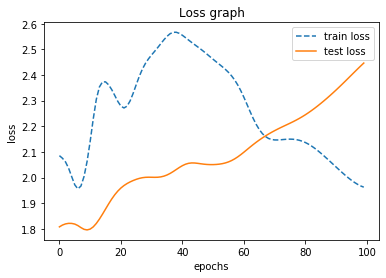

In [469]:
print('< RNN+SGD+50d >', '\n')
#emoji
for i in range(len(X_test)):
    print(X_test[i], ' ', label_to_emoji(np.argmax(softmax(network.predict(x_test)[ : , : , -1].T[i]))))
print('\n')
#Acc
print("Final Test Accuracy : ", test_acc_list[-1])

#Loss Graph
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_loss_list))
plt.plot(x, train_loss_list, label='train loss', linestyle='--')
plt.plot(x, test_loss_list, label='test loss')
plt.title('Loss graph')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc='upper right')
plt.show()



### LSTM+SGD+50d

In [480]:

#parameter
batchsize = 6
numx = len(word_to_vec_map['a'])
numh = 100 
numy = 5
vecmap_len = len(word_to_vec_map['a'])

            
network = LSTM(num_of_x=numx, num_of_hidden=numh, num_of_y=numy)

train_size = len(X_train_indices)
test_size = len(X_test)
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

learning_rate = 0.05
# 1epoch당 반복 수
iter_per_epoch = int(max(train_size / batchsize, 1))

max_epochs = 50
iters_num = int(iter_per_epoch * max_epochs)
for j in range(iters_num):
    #기울기
    grad = network.gradient(x_batch, t_batch)
    # 매개변수 갱신
    network.parameters['Wf2'] -= learning_rate * grad['Wf2']
    network.parameters['Wi2'] -= learning_rate * grad['Wi2']
    network.parameters['Wc2'] -= learning_rate * grad['Wc2']
    network.parameters['Wo2'] -= learning_rate * grad['Wo2']
    network.parameters['bf2'] -= learning_rate * grad['bf2']
    network.parameters['bi2'] -= learning_rate * grad['bi2']
    network.parameters['bc2'] -= learning_rate * grad['bc2']
    network.parameters['bo2'] -= learning_rate * grad['bo2']
    network.parameters['Wf1'] -= learning_rate * grad['Wf1']
    network.parameters['Wi1'] -= learning_rate * grad['Wi1']
    network.parameters['Wc1'] -= learning_rate * grad['Wc1']
    network.parameters['Wo1'] -= learning_rate * grad['Wo1']
    network.parameters['bf1'] -= learning_rate * grad['bf1']
    network.parameters['bi1'] -= learning_rate * grad['bi1']
    network.parameters['bc1'] -= learning_rate * grad['bc1']
    network.parameters['bo1'] -= learning_rate * grad['bo1']
    # acc 계산
    if j % iter_per_epoch == 0:
        loss = network.loss(x_batch, t_batch)
        train_loss_list.append(loss)

        loss_test = network.loss(x_test_batch, t_test_batch)
        test_loss_list.append(loss_test)
        train_acc = network.accuracy(x_train , t_train)
        train_acc_list.append(train_acc)
        test_acc = network.accuracy(x_test, t_test)
        test_acc_list.append(test_acc)
        print("Epoch", int(j/iter_per_epoch), "--- train acc : " + str(train_acc), "/", "test acc : " + str(test_acc))


Epoch 0 --- train acc : 15.1515 / test acc : 14.2857
Epoch 1 --- train acc : 18.9394 / test acc : 17.8571
Epoch 2 --- train acc : 18.9394 / test acc : 16.0714
Epoch 3 --- train acc : 17.4242 / test acc : 16.0714
Epoch 4 --- train acc : 15.1515 / test acc : 14.2857
Epoch 5 --- train acc : 15.1515 / test acc : 16.0714
Epoch 6 --- train acc : 14.3939 / test acc : 10.7143
Epoch 7 --- train acc : 12.8788 / test acc : 8.9286
Epoch 8 --- train acc : 12.8788 / test acc : 14.2857
Epoch 9 --- train acc : 12.1212 / test acc : 10.7143
Epoch 10 --- train acc : 15.1515 / test acc : 16.0714
Epoch 11 --- train acc : 17.4242 / test acc : 17.8571
Epoch 12 --- train acc : 18.1818 / test acc : 21.4286
Epoch 13 --- train acc : 20.4545 / test acc : 25.0
Epoch 14 --- train acc : 21.2121 / test acc : 26.7857
Epoch 15 --- train acc : 18.9394 / test acc : 23.2143
Epoch 16 --- train acc : 21.2121 / test acc : 21.4286
Epoch 17 --- train acc : 19.697 / test acc : 23.2143
Epoch 18 --- train acc : 18.9394 / test acc

< LSTM+SGD+50d > 

I want to eat	   ❤️
he did not answer	   😄
he got a very nice raise	   😄
she got me a nice present	   ❤️
ha ha ha it was so funny	   😄
he is a good friend	   😄
I am upset	   ❤️
We had such a lovely dinner tonight	   😄
where is the food	   🍴
Stop making this joke ha ha ha	   😄
where is the ball	   😄
work is hard	   ❤️
This girl is messing with me	   🍴
are you serious   😞
Let us go play baseball	   😞
This stupid grader is not working 	   ❤️
work is horrible	   ❤️
Congratulation for having a baby	   😄
stop pissing me off   😞
any suggestions for dinner	   🍴
I love taking breaks	   ❤️
you brighten my day	   ⚾
I boiled rice	   ⚾
she is a bully	   😄
Why are you feeling bad	   😞
I am upset	   ❤️
give me the ball   😄
My grandmother is the love of my life	   🍴
enjoy your game   😞
valentine day is near	   😄
I miss you so much	   ❤️
throw the ball	   😄
My life is so boring	   🍴
she said yes	   😄
will you be my valentine	   😞
he can pitch really well	   😄
dance with me	   ⚾
I am 

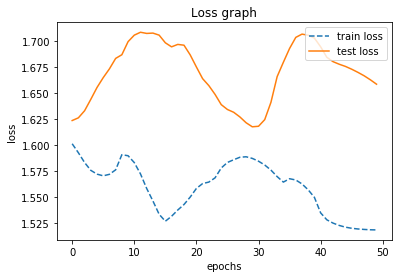

In [481]:
print('< LSTM+SGD+50d >', '\n')
#emoji
for i in range(len(X_test)):
    print(X_test[i], ' ', label_to_emoji(np.argmax(softmax(network.predict(x_test)[ : , : , -1].T[i]))))
print('\n')
#Acc
print("Final Test Accuracy : ", test_acc_list[-1])

#Loss Graph
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_loss_list))
plt.plot(x, train_loss_list, label='train loss', linestyle='--')
plt.plot(x, test_loss_list, label='test loss')
plt.title('Loss graph')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc='upper right')
plt.show()


### LSTM+ADAM+50d

In [663]:
#parameter
            
class Adam:

    """Adam (http://arxiv.org/abs/1412.6980v8)"""

    def __init__(self, lr=0.0001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)

adam = Adam()

batchsize = 6
numx = len(word_to_vec_map['a'])
numh = 50 
numy = 5
vecmap_len = len(word_to_vec_map['a'])

            
network = LSTM(num_of_x=numx, num_of_hidden=numh, num_of_y=numy)

train_size = len(X_train_indices)
test_size = len(X_test)
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

# 1epoch당 반복 수
iter_per_epoch = int(max(train_size / batchsize, 1))

max_epochs = 50
iters_num = int(iter_per_epoch * max_epochs)
for j in range(iters_num):
    #기울기
    grad = network.gradient(x_batch, t_batch)
    # 매개변수 갱신
    adam.update(network.parameters, grad)
    # acc 계산
    if j % iter_per_epoch == 0:
        loss = network.loss(x_batch, t_batch)
        train_loss_list.append(loss)

        loss_test = network.loss(x_test_batch, t_test_batch)
        test_loss_list.append(loss_test)
        train_acc = network.accuracy(x_train , t_train)
        train_acc_list.append(train_acc)
        test_acc = network.accuracy(x_test, t_test)
        test_acc_list.append(test_acc)
        print("Epoch", int(j/iter_per_epoch), "--- train acc : " + str(train_acc), "/", "test acc : " + str(test_acc))


Epoch 0 --- train acc : 21.2121 / test acc : 16.0714
Epoch 1 --- train acc : 23.4848 / test acc : 16.0714
Epoch 2 --- train acc : 21.2121 / test acc : 21.4286
Epoch 3 --- train acc : 21.2121 / test acc : 28.5714
Epoch 4 --- train acc : 23.4848 / test acc : 30.3571
Epoch 5 --- train acc : 25.0 / test acc : 30.3571
Epoch 6 --- train acc : 24.2424 / test acc : 30.3571
Epoch 7 --- train acc : 25.0 / test acc : 26.7857
Epoch 8 --- train acc : 25.0 / test acc : 26.7857
Epoch 9 --- train acc : 25.0 / test acc : 25.0
Epoch 10 --- train acc : 23.4848 / test acc : 28.5714
Epoch 11 --- train acc : 23.4848 / test acc : 32.1429
Epoch 12 --- train acc : 23.4848 / test acc : 32.1429
Epoch 13 --- train acc : 25.0 / test acc : 32.1429
Epoch 14 --- train acc : 25.7576 / test acc : 32.1429
Epoch 15 --- train acc : 25.7576 / test acc : 33.9286
Epoch 16 --- train acc : 24.2424 / test acc : 35.7143
Epoch 17 --- train acc : 25.0 / test acc : 33.9286
Epoch 18 --- train acc : 23.4848 / test acc : 33.9286
Epoch

< LSTM+ADAM+50d > 

I want to eat	   😄
he did not answer	   ⚾
he got a very nice raise	   😄
she got me a nice present	   😄
ha ha ha it was so funny	   😄
he is a good friend	   🍴
I am upset	   😞
We had such a lovely dinner tonight	   🍴
where is the food	   😞
Stop making this joke ha ha ha	   😄
where is the ball	   😞
work is hard	   😞
This girl is messing with me	   ⚾
are you serious   😞
Let us go play baseball	   ⚾
This stupid grader is not working 	   🍴
work is horrible	   😞
Congratulation for having a baby	   😞
stop pissing me off   😞
any suggestions for dinner	   😞
I love taking breaks	   😄
you brighten my day	   😄
I boiled rice	   😞
she is a bully	   🍴
Why are you feeling bad	   😄
I am upset	   😞
give me the ball   😄
My grandmother is the love of my life	   ❤️
enjoy your game   😞
valentine day is near	   😞
I miss you so much	   😄
throw the ball	   😞
My life is so boring	   😄
she said yes	   😞
will you be my valentine	   🍴
he can pitch really well	   😄
dance with me	   😞
I am hungry 

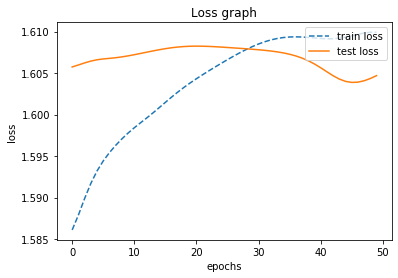

In [664]:
print('< LSTM+ADAM+50d >', '\n')
#emoji
for i in range(len(X_test)):
    print(X_test[i], ' ', label_to_emoji(np.argmax(softmax(network.predict(x_test)[ : , : , -1].T[i]))))
print('\n')
#Acc
print("Final Test Accuracy : ", test_acc_list[-1])

#Loss Graph
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_loss_list))
plt.plot(x, train_loss_list, label='train loss', linestyle='--')
plt.plot(x, test_loss_list, label='test loss')
plt.title('Loss graph')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc='upper right')
plt.show()

### LSTM SGD 100d

In [680]:
#preprocessing

word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('./glove.6B/glove.6B.100d.txt')

# add index 0 -> zero mapping
index_to_word[0] = 'temp0'
word_to_index['temp0'] = 0
word_to_vec_map['temp0'] = np.zeros(100)
                                                                
X_train_indices = sentences_to_indices(X_train, word_to_index, maxLen)
Y_train_oh = convert_to_one_hot(Y_train, C=5)
                                                                
X_test_indices = sentences_to_indices(X_test, word_to_index, max_len=maxLen)
Y_test_oh = convert_to_one_hot(Y_test, C=5)


In [682]:
#parameter
batchsize = 6
numx = len(word_to_vec_map['a'])
numh = 100 
numy = 5
vecmap_len = len(word_to_vec_map['a'])

train_size = len(X_train_indices)
test_size = len(X_test)
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []
             
#-------------------------------------------

'''Data preprocessing'''

#Make train & input reshape (132,)
arr2 = np.empty((0, maxLen, vecmap_len), int)
arr3 = np.empty((0, numy), int)
batch_mask = np.random.choice(train_size, batchsize)
for i in range(batchsize):
    arr = np.empty((0, vecmap_len), int)
    for j in range(maxLen):
        word = index_to_word[X_train_indices[batch_mask[i]][j]]
        arr = np.append(arr, np.array([word_to_vec_map[word]]), axis=0)
    arr2 = np.append(arr2, np.array([arr]), axis=0)
    arr3 = np.append(arr3, np.array([Y_train_oh[batch_mask[i]]]),axis=0)
input_arr = np.transpose(arr2, (2,0,1))

x_batch = input_arr
t_batch = arr3

#Make test & input reshape
arr2 = np.empty((0, maxLen, vecmap_len), int)
arr3 = np.empty((0, numy), int)
batch_mask = np.random.choice(test_size, batchsize)
for i in range(batchsize):
    arr = np.empty((0, vecmap_len), int)
    for j in range(maxLen):
        word = index_to_word[X_test_indices[batch_mask[i]][j]]
        arr = np.append(arr, np.array([word_to_vec_map[word]]), axis=0)
    arr2 = np.append(arr2, np.array([arr]), axis=0)
    arr3 = np.append(arr3, np.array([Y_test_oh[batch_mask[i]]]),axis=0)
input_arr = np.transpose(arr2, (2,0,1))

x_test_batch = input_arr
t_test_batch = arr3

#make all data reshape for accuracy
arr2 = np.empty((0, maxLen, vecmap_len), int)
arr3 = np.empty((0, numy), int)
for i in range(train_size):
    arr = np.empty((0, vecmap_len), int)
    for j in range(maxLen):
        word = index_to_word[X_train_indices[i][j]]
        arr = np.append(arr, np.array([word_to_vec_map[word]]), axis=0)
    arr2 = np.append(arr2, np.array([arr]), axis=0)
    arr3 = np.append(arr3, np.array([Y_train_oh[i]]),axis=0)
input_arr = np.transpose(arr2, (2,0,1))

x_train = input_arr
t_train = arr3

arr2 = np.empty((0, maxLen, vecmap_len), int)
arr3 = np.empty((0, numy), int)
for i in range(test_size):
    arr = np.empty((0, vecmap_len), int)
    for j in range(maxLen):
        word = index_to_word[X_test_indices[i][j]]
        arr = np.append(arr, np.array([word_to_vec_map[word]]), axis=0)
    arr2 = np.append(arr2, np.array([arr]), axis=0)
    arr3 = np.append(arr3, np.array([Y_test_oh[i]]),axis=0)
input_arr = np.transpose(arr2, (2,0,1))

x_test = input_arr
t_test = arr3

'''Training Procedure'''

#Do RNN\
network = LSTM(num_of_x=numx, num_of_hidden=numh, num_of_y=numy)

train_size = len(X_train_indices)
test_size = len(X_test)
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

learning_rate = 0.005
# 1epoch당 반복 수
iter_per_epoch = int(max(train_size / batchsize, 1))

max_epochs = 50
iters_num = int(iter_per_epoch * max_epochs)
for j in range(iters_num):
    #기울기
    grad = network.gradient(x_batch, t_batch)
    # 매개변수 갱신
    network.parameters['Wf2'] -= learning_rate * grad['Wf2']
    network.parameters['Wi2'] -= learning_rate * grad['Wi2']
    network.parameters['Wc2'] -= learning_rate * grad['Wc2']
    network.parameters['Wo2'] -= learning_rate * grad['Wo2']
    network.parameters['bf2'] -= learning_rate * grad['bf2']
    network.parameters['bi2'] -= learning_rate * grad['bi2']
    network.parameters['bc2'] -= learning_rate * grad['bc2']
    network.parameters['bo2'] -= learning_rate * grad['bo2']
    network.parameters['Wf1'] -= learning_rate * grad['Wf1']
    network.parameters['Wi1'] -= learning_rate * grad['Wi1']
    network.parameters['Wc1'] -= learning_rate * grad['Wc1']
    network.parameters['Wo1'] -= learning_rate * grad['Wo1']
    network.parameters['bf1'] -= learning_rate * grad['bf1']
    network.parameters['bi1'] -= learning_rate * grad['bi1']
    network.parameters['bc1'] -= learning_rate * grad['bc1']
    network.parameters['bo1'] -= learning_rate * grad['bo1']
    # acc 계산
    if j % iter_per_epoch == 0:
        loss = network.loss(x_batch, t_batch)
        train_loss_list.append(loss)

        loss_test = network.loss(x_test_batch, t_test_batch)
        test_loss_list.append(loss_test)
        train_acc = network.accuracy(x_train , t_train)
        train_acc_list.append(train_acc)
        test_acc = network.accuracy(x_test, t_test)
        test_acc_list.append(test_acc)
        print("Epoch", int(j/iter_per_epoch), "--- train acc : " + str(train_acc), "/", "test acc : " + str(test_acc))


Epoch 0 --- train acc : 14.3939 / test acc : 19.6429
Epoch 1 --- train acc : 17.4242 / test acc : 19.6429
Epoch 2 --- train acc : 19.697 / test acc : 17.8571
Epoch 3 --- train acc : 21.9697 / test acc : 16.0714
Epoch 4 --- train acc : 18.1818 / test acc : 16.0714
Epoch 5 --- train acc : 18.9394 / test acc : 16.0714
Epoch 6 --- train acc : 17.4242 / test acc : 17.8571
Epoch 7 --- train acc : 17.4242 / test acc : 17.8571
Epoch 8 --- train acc : 16.6667 / test acc : 16.0714
Epoch 9 --- train acc : 16.6667 / test acc : 16.0714
Epoch 10 --- train acc : 17.4242 / test acc : 16.0714
Epoch 11 --- train acc : 17.4242 / test acc : 17.8571
Epoch 12 --- train acc : 19.697 / test acc : 21.4286
Epoch 13 --- train acc : 19.697 / test acc : 25.0
Epoch 14 --- train acc : 18.9394 / test acc : 25.0
Epoch 15 --- train acc : 18.1818 / test acc : 25.0
Epoch 16 --- train acc : 18.1818 / test acc : 25.0
Epoch 17 --- train acc : 18.1818 / test acc : 25.0
Epoch 18 --- train acc : 17.4242 / test acc : 25.0
Epoch

< LSTM+SGD+100d > 

I want to eat	   😞
he did not answer	   😞
he got a very nice raise	   ❤️
she got me a nice present	   ❤️
ha ha ha it was so funny	   😄
he is a good friend	   😄
I am upset	   😞
We had such a lovely dinner tonight	   🍴
where is the food	   ❤️
Stop making this joke ha ha ha	   ❤️
where is the ball	   😄
work is hard	   😞
This girl is messing with me	   ❤️
are you serious   😄
Let us go play baseball	   😞
This stupid grader is not working 	   ❤️
work is horrible	   🍴
Congratulation for having a baby	   🍴
stop pissing me off   ❤️
any suggestions for dinner	   🍴
I love taking breaks	   😞
you brighten my day	   ⚾
I boiled rice	   😞
she is a bully	   🍴
Why are you feeling bad	   😞
I am upset	   😞
give me the ball   😞
My grandmother is the love of my life	   😄
enjoy your game   😞
valentine day is near	   🍴
I miss you so much	   😄
throw the ball	   🍴
My life is so boring	   🍴
she said yes	   ⚾
will you be my valentine	   😄
he can pitch really well	   😞
dance with me	   ⚾
I am h

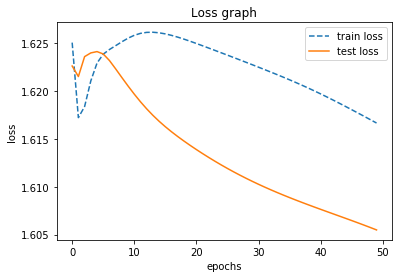

In [683]:
print('< LSTM+SGD+100d >', '\n')
#emoji
for i in range(len(X_test)):
    print(X_test[i], ' ', label_to_emoji(np.argmax(softmax(network.predict(x_test)[ : , : , -1].T[i]))))
print('\n')
#Acc
print("Final Test Accuracy : ", test_acc_list[-1])

#Loss Graph
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_loss_list))
plt.plot(x, train_loss_list, label='train loss', linestyle='--')
plt.plot(x, test_loss_list, label='test loss')
plt.title('Loss graph')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc='upper right')
plt.show()

### LSTM SGD 50d dropout

In [566]:
#preprocessing

word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('./glove.6B/glove.6B.50d.txt')

# add index 0 -> zero mapping
index_to_word[0] = 'temp0'
word_to_index['temp0'] = 0
word_to_vec_map['temp0'] = np.zeros(50)
                                                                
X_train_indices = sentences_to_indices(X_train, word_to_index, maxLen)
Y_train_oh = convert_to_one_hot(Y_train, C=5)
                                                                
X_test_indices = sentences_to_indices(X_test, word_to_index, max_len=maxLen)
Y_test_oh = convert_to_one_hot(Y_test, C=5)


In [677]:

batchsize = 6
numx = len(word_to_vec_map['a'])
numh = 50
numy = 5
vecmap_len = len(word_to_vec_map['a'])

train_size = len(X_train_indices)
test_size = len(X_test)
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []
             
#-------------------------------------------

'''Data preprocessing'''

#Make train & input reshape (132,)
arr2 = np.empty((0, maxLen, vecmap_len), int)
arr3 = np.empty((0, numy), int)
batch_mask = np.random.choice(train_size, batchsize)
for i in range(batchsize):
    arr = np.empty((0, vecmap_len), int)
    for j in range(maxLen):
        word = index_to_word[X_train_indices[batch_mask[i]][j]]
        arr = np.append(arr, np.array([word_to_vec_map[word]]), axis=0)
    arr2 = np.append(arr2, np.array([arr]), axis=0)
    arr3 = np.append(arr3, np.array([Y_train_oh[batch_mask[i]]]),axis=0)
input_arr = np.transpose(arr2, (2,0,1))

x_batch = input_arr
t_batch = arr3

#Make test & input reshape
arr2 = np.empty((0, maxLen, vecmap_len), int)
arr3 = np.empty((0, numy), int)
batch_mask = np.random.choice(test_size, batchsize)
for i in range(batchsize):
    arr = np.empty((0, vecmap_len), int)
    for j in range(maxLen):
        word = index_to_word[X_test_indices[batch_mask[i]][j]]
        arr = np.append(arr, np.array([word_to_vec_map[word]]), axis=0)
    arr2 = np.append(arr2, np.array([arr]), axis=0)
    arr3 = np.append(arr3, np.array([Y_test_oh[batch_mask[i]]]),axis=0)
input_arr = np.transpose(arr2, (2,0,1))

x_test_batch = input_arr
t_test_batch = arr3

#make all data reshape for accuracy
arr2 = np.empty((0, maxLen, vecmap_len), int)
arr3 = np.empty((0, numy), int)
for i in range(train_size):
    arr = np.empty((0, vecmap_len), int)
    for j in range(maxLen):
        word = index_to_word[X_train_indices[i][j]]
        arr = np.append(arr, np.array([word_to_vec_map[word]]), axis=0)
    arr2 = np.append(arr2, np.array([arr]), axis=0)
    arr3 = np.append(arr3, np.array([Y_train_oh[i]]),axis=0)
input_arr = np.transpose(arr2, (2,0,1))

x_train = input_arr
t_train = arr3

arr2 = np.empty((0, maxLen, vecmap_len), int)
arr3 = np.empty((0, numy), int)
for i in range(test_size):
    arr = np.empty((0, vecmap_len), int)
    for j in range(maxLen):
        word = index_to_word[X_test_indices[i][j]]
        arr = np.append(arr, np.array([word_to_vec_map[word]]), axis=0)
    arr2 = np.append(arr2, np.array([arr]), axis=0)
    arr3 = np.append(arr3, np.array([Y_test_oh[i]]),axis=0)
input_arr = np.transpose(arr2, (2,0,1))

x_test = input_arr
t_test = arr3

In [678]:
     
network = LSTM(num_of_x=numx, num_of_hidden=numh, num_of_y=numy,dropout=True)

train_size = len(X_train_indices)
test_size = len(X_test)
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

learning_rate = 0.005
# 1epoch당 반복 수
iter_per_epoch = int(max(train_size / batchsize, 1))

max_epochs = 50
iters_num = int(iter_per_epoch * max_epochs)
for j in range(iters_num):
    #기울기
    grad = network.gradient(x_batch, t_batch)
    # 매개변수 갱신
    network.parameters['Wf2'] -= learning_rate * grad['Wf2']
    network.parameters['Wi2'] -= learning_rate * grad['Wi2']
    network.parameters['Wc2'] -= learning_rate * grad['Wc2']
    network.parameters['Wo2'] -= learning_rate * grad['Wo2']
    network.parameters['bf2'] -= learning_rate * grad['bf2']
    network.parameters['bi2'] -= learning_rate * grad['bi2']
    network.parameters['bc2'] -= learning_rate * grad['bc2']
    network.parameters['bo2'] -= learning_rate * grad['bo2']
    network.parameters['Wf1'] -= learning_rate * grad['Wf1']
    network.parameters['Wi1'] -= learning_rate * grad['Wi1']
    network.parameters['Wc1'] -= learning_rate * grad['Wc1']
    network.parameters['Wo1'] -= learning_rate * grad['Wo1']
    network.parameters['bf1'] -= learning_rate * grad['bf1']
    network.parameters['bi1'] -= learning_rate * grad['bi1']
    network.parameters['bc1'] -= learning_rate * grad['bc1']
    network.parameters['bo1'] -= learning_rate * grad['bo1']
    # acc 계산
    if j % iter_per_epoch == 0:
        loss = network.loss(x_batch, t_batch)
        train_loss_list.append(loss)

        loss_test = network.loss(x_test_batch, t_test_batch)
        test_loss_list.append(loss_test)
        train_acc = network.accuracy(x_train , t_train)
        train_acc_list.append(train_acc)
        test_acc = network.accuracy(x_test, t_test)
        test_acc_list.append(test_acc)
        print("Epoch", int(j/iter_per_epoch), "--- train acc : " + str(train_acc), "/", "test acc : " + str(test_acc))


Epoch 0 --- train acc : 15.9091 / test acc : 12.5
Epoch 1 --- train acc : 21.9697 / test acc : 25.0
Epoch 2 --- train acc : 22.7273 / test acc : 8.9286
Epoch 3 --- train acc : 18.9394 / test acc : 14.2857
Epoch 4 --- train acc : 12.8788 / test acc : 21.4286
Epoch 5 --- train acc : 14.3939 / test acc : 12.5
Epoch 6 --- train acc : 22.7273 / test acc : 21.4286
Epoch 7 --- train acc : 21.9697 / test acc : 16.0714
Epoch 8 --- train acc : 25.0 / test acc : 16.0714
Epoch 9 --- train acc : 20.4545 / test acc : 12.5
Epoch 10 --- train acc : 22.7273 / test acc : 19.6429
Epoch 11 --- train acc : 19.697 / test acc : 19.6429
Epoch 12 --- train acc : 18.9394 / test acc : 21.4286
Epoch 13 --- train acc : 21.2121 / test acc : 21.4286
Epoch 14 --- train acc : 22.7273 / test acc : 14.2857
Epoch 15 --- train acc : 22.7273 / test acc : 17.8571
Epoch 16 --- train acc : 19.697 / test acc : 19.6429
Epoch 17 --- train acc : 21.9697 / test acc : 12.5
Epoch 18 --- train acc : 20.4545 / test acc : 23.2143
Epoch

< LSTM+SGD+50d+drouout > 

I want to eat	   🍴
he did not answer	   😞
he got a very nice raise	   🍴
she got me a nice present	   😄
ha ha ha it was so funny	   😞
he is a good friend	   😄
I am upset	   ⚾
We had such a lovely dinner tonight	   😄
where is the food	   🍴
Stop making this joke ha ha ha	   😞
where is the ball	   ❤️
work is hard	   ❤️
This girl is messing with me	   ❤️
are you serious   ⚾
Let us go play baseball	   ❤️
This stupid grader is not working 	   🍴
work is horrible	   ⚾
Congratulation for having a baby	   😄
stop pissing me off   ⚾
any suggestions for dinner	   ⚾
I love taking breaks	   ❤️
you brighten my day	   ❤️
I boiled rice	   ⚾
she is a bully	   😞
Why are you feeling bad	   🍴
I am upset	   ⚾
give me the ball   ❤️
My grandmother is the love of my life	   ❤️
enjoy your game   ❤️
valentine day is near	   😞
I miss you so much	   🍴
throw the ball	   😄
My life is so boring	   😞
she said yes	   😞
will you be my valentine	   😄
he can pitch really well	   🍴
dance with me	  

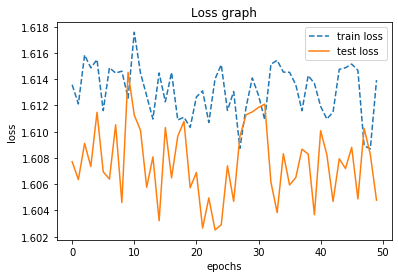

In [679]:
print('< LSTM+SGD+50d+drouout >', '\n')
#emoji
for i in range(len(X_test)):
    print(X_test[i], ' ', label_to_emoji(np.argmax(softmax(network.predict(x_test)[ : , : , -1].T[i]))))
print('\n')
#Acc
print("Final Test Accuracy : ", test_acc_list[-1])

#Loss Graph
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_loss_list))
plt.plot(x, train_loss_list, label='train loss', linestyle='--')
plt.plot(x, test_loss_list, label='test loss')
plt.title('Loss graph')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc='upper right')
plt.show()